In [24]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from sklearn.linear_model import LinearRegression

from matplotlib import font_manager, rc
font_path = "C:/Windows/Fonts/NGULIM.TTF"
font = font_manager.FontProperties(fname=font_path).get_name()
rc('font', family=font)

import warnings

warnings.filterwarnings("ignore")

train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
train_money = pd.read_csv('train_final.csv')


error_data = ['C2085', 'C1397', 'C2431', 'C1649', 'C1095', 'C2051', 'C1218', 'C1894', 'C2483', 'C1502', 'C1988']

for error in error_data :
    train = train[train['단지코드'] != error]
    

# train = train[train.단지코드 != 'C1804']
# train = train[train.단지코드 != 'C2405']
# train = train[train.단지코드 != 'C1740']
# train = train[train.단지코드 != 'C1206']

train.loc[train.임대보증금=='-', '임대보증금'] = np.nan
test.loc[test.임대보증금=='-', '임대보증금'] = np.nan
train['임대보증금'] = train['임대보증금'].astype(float)
test['임대보증금'] = test['임대보증금'].astype(float)

train.loc[train.임대료=='-', '임대료'] = np.nan
test.loc[test.임대료=='-', '임대료'] = np.nan
train['임대료'] = train['임대료'].astype(float)
test['임대료'] = test['임대료'].astype(float)

train[['임대보증금', '임대료']] = train[['임대보증금', '임대료']].fillna(0)
test[['임대보증금', '임대료']] = test[['임대보증금', '임대료']].fillna(0)

cols = ['도보 10분거리 내 지하철역 수(환승노선 수 반영)', '도보 10분거리 내 버스정류장 수']
train[cols] = train[cols].fillna(0)
test[cols] = test[cols].fillna(0)

test.loc[test.단지코드.isin(['C2411']) & test.자격유형.isnull(), '자격유형'] = 'A'
test.loc[test.단지코드.isin(['C2253']) & test.자격유형.isnull(), '자격유형'] = 'C'

train = train.drop_duplicates()
test = test.drop_duplicates()

unique_cols = ['총세대수', '지역', '공가수', 
               '도보 10분거리 내 지하철역 수(환승노선 수 반영)',
               '도보 10분거리 내 버스정류장 수',
               '단지내주차면수', '등록차량수']
train_agg = train.set_index('단지코드')[unique_cols].drop_duplicates()
test_agg = test.set_index('단지코드')[[col for col in unique_cols if col!='등록차량수']].drop_duplicates()


def reshape_cat_features(data, cast_col, value_col):
    res = data.drop_duplicates(['단지코드', cast_col]).assign(counter=1).pivot(index='단지코드', columns=cast_col, values=value_col).fillna(0)
    res.columns.name = None
    res = res.rename(columns={col:cast_col+'_'+str(col) for col in res.columns})
    return res



train.loc[train.공급유형.isin(['공공임대(5년)', '공공분양', '공공임대(10년)', '공공임대(분납)']), '공급유형'] = '공공임대(5년/10년/분납/분양)'
test.loc[test.공급유형.isin(['공공임대(5년)', '공공분양', '공공임대(10년)', '공공임대(분납)']), '공급유형'] = '공공임대(5년/10년/분납/분양)'
train.loc[train.공급유형.isin(['장기전세', '국민임대']), '공급유형'] = '국민임대/장기전세'
test.loc[test.공급유형.isin(['장기전세', '국민임대']), '공급유형'] = '국민임대/장기전세'

train.loc[train.자격유형.isin(['J', 'L', 'K', 'N', 'M', 'O']), '자격유형'] = '행복주택_공급대상'
test.loc[test.자격유형.isin(['J', 'L', 'K', 'N', 'M', 'O']), '자격유형'] = '행복주택_공급대상'

train.loc[train.자격유형.isin(['H', 'B', 'E', 'G']), '자격유형'] = '국민임대/장기전세_공급대상'
test.loc[test.자격유형.isin(['H', 'B', 'E', 'G']), '자격유형'] = '국민임대/장기전세_공급대상'

train.loc[train.자격유형.isin(['C', 'I', 'F']), '자격유형'] = '영구임대_공급대상'
test.loc[test.자격유형.isin(['C', 'I', 'F']), '자격유형'] = '영구임대_공급대상'


X_train = pd.concat([train_agg,
                       reshape_cat_features(data=train, cast_col='임대건물구분', value_col='counter'),
                       reshape_cat_features(data=train, cast_col='공급유형', value_col='counter'),
                       reshape_cat_features(data=train, cast_col='자격유형', value_col='counter'),
                       ], axis=1)

X_test = pd.concat([test_agg,
                       reshape_cat_features(data=test, cast_col='임대건물구분', value_col='counter'),
                       reshape_cat_features(data=test, cast_col='공급유형', value_col='counter'),
                       reshape_cat_features(data=test, cast_col='자격유형', value_col='counter'),
                  ], axis=1)

region_regi_car = X_train.groupby(['지역'])['등록차량수','총세대수'].sum()
region_regi_car


region_regi_car['지역_세대당차량수'] = region_regi_car['등록차량수'] / region_regi_car['총세대수']
region_mapping = region_regi_car.drop(['등록차량수','총세대수'],axis=1)
region_mapping

mapping_values = []
for r in X_train['지역'].values:
    mapping_values.extend([region_mapping.loc[r].values])
region_car = pd.DataFrame(mapping_values, columns = ['지역_세대당차량수'], index = X_train.index)
X_train = pd.concat([X_train,region_car], axis= 1).drop(columns = ['지역'])

mapping_values = []
for r in X_test['지역'].values:
    mapping_values.extend([region_mapping.loc[r].values])
region_car = pd.DataFrame(mapping_values, columns = ['지역_세대당차량수'], index = X_test.index)
X_test = pd.concat([X_test,region_car], axis= 1).drop(columns = ['지역'])

from sklearn.preprocessing import StandardScaler
scailing_features = ['총세대수',
                     '공가수',
                     '도보 10분거리 내 버스정류장 수',
                     '단지내주차면수',
                     '도보 10분거리 내 지하철역 수(환승노선 수 반영)',
                     '지역_세대당차량수'
                    ]

# scaler = StandardScaler()
# X_train.loc[:, scailing_features] = scaler.fit_transform(X_train[scailing_features])
# X_test.loc[:, scailing_features] = scaler.transform(X_test[scailing_features])

X_train.loc[:,scailing_features] = np.log1p(X_train[scailing_features])
X_test.loc[:,scailing_features] = np.log1p(X_test[scailing_features])

In [25]:
from sklearn.model_selection import KFold

def kfold_val(n, model, X_data, y_target,expm1):
    kfold = KFold(n_splits=n)
    cv_mae=[]

    n_iter = 0 

    for train_index, test_index in kfold.split(X_data):
        X_train, X_test = X_data.iloc[train_index], X_data.iloc[test_index]
        y_train, y_test = y_target[train_index], y_target[test_index]
        # 학습 및 예측

        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        n_iter += 1

        if expm1 :
            y_t = np.expm1(y_test)
            y_p = np.expm1(y_pred)
        else:
            y_t = y_test
            y_p = t_pred

        a = 0
        mae = mean_absolute_error(y_t,y_p)
        train_size = X_train.shape[0]
        test_size = X_test.shape[0]
#         print('\n#{0} 교차 검증 MAE :{1}, 학습 데이터 크기: {2}, 검증 데이터 크기: {3}'.format(n_iter, mae, train_size, test_size))
        cv_mae.append(mae)
    # 개별 iteration별 정확도를 합하여 평균 정확도 계산
    print(model, '\n## 평균 검증 MAE:', np.mean(cv_mae))
    return np.mean(cv_mae)

In [26]:
from sklearn.model_selection import GridSearchCV

def get_best_params(model, params,X_data, y_target):
    grid_model = GridSearchCV(model, param_grid=params, 
                              scoring='neg_mean_absolute_error', cv=10)
    grid_model.fit(X_data, y_target)
    mae = -1 *  grid_model.best_score_
    print('{0} 5 CV 시 최적 평균 로그 변환된 MAE 값: {1}, 최적 alpha:{2}'.format(model.__class__.__name__,
                                        np.round(mae, 4), grid_model.best_params_))
    return grid_model.best_estimator_

In [27]:
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import PolynomialFeatures


def get_scaled_data(method='None', p_degree=None, input_data=None):
    if method == 'Standard':
        scaled_data = StandardScaler().fit_transform(input_data)
    elif method =='MinMax':
        scaled_data = MinMaxScaler().fit_transform(input_data)
    elif method == 'Log':
        scaled_data = np.log1p(input_data)
    else:
        scaled_data = input_data
    
    if p_degree != None:
        scaled_data = PolynomialFeatures(degree=p_degree, include_bias=False).fit_transform(scaled_data)
    
    return scaled_data

In [28]:
X = X_train.drop(columns = ['등록차량수'], axis=1)
y = np.log1p(X_train['등록차량수'])

In [31]:
X_smote = X_train.drop(['임대건물구분_상가'],axis=1)
y_smote = X['임대건물구분_상가']
# imbalanced-learn 패키지
from imblearn.over_sampling import SMOTE

# SMOTE 객체 생성
smote = SMOTE(random_state=42)
    
# 샘플링
X_over, y_over = smote.fit_resample(X_smote, y_smote)
train_over = pd.concat([X_over, y_over], axis=1)

X = train_over.drop(columns = ['등록차량수'], axis=1)
y = np.log1p(train_over['등록차량수'])

In [39]:
from sklearn.linear_model import Ridge, Lasso, ElasticNet
X_scaled = get_scaled_data(method=None, p_degree=None, input_data=X)
X_scaled = pd.DataFrame(X_scaled)

ridge_params = {'alpha' : [0.05,0.1,1,5,8,10,12,15,20]}
lasso_params = {'alpha' : [0.001,0.005, 0.008,0.05, 0.03, 0.1, 0.5, 1.5,10]}
elastic_params = {'alpha' : [0.001,0.005, 0.008,0.05, 0.03, 0.1, 0.5, 1.5,10]}

ridge_reg = Ridge()
lasso_reg = Lasso()
elastic_reg = ElasticNet()

best_ridge=get_best_params(ridge_reg,ridge_params,X_scaled,y)
best_lasso = get_best_params(lasso_reg,lasso_params,X_scaled,y)
best_elastic = get_best_params(elastic_reg,elastic_params,X_scaled,y)

# lr_reg = LinearRegression()
ridge_reg = Ridge(alpha=best_ridge.alpha)
lasso_reg = Lasso(alpha=best_lasso.alpha)
elastic_reg = ElasticNet(alpha=best_elastic.alpha)

# 성능 평가
models = [ridge_reg, lasso_reg, elastic_reg]

for model in models:
    kfold_val(7, model, X_scaled, y,True)
    

Ridge 5 CV 시 최적 평균 로그 변환된 MAE 값: 0.2463, 최적 alpha:{'alpha': 0.1}
Lasso 5 CV 시 최적 평균 로그 변환된 MAE 값: 0.2484, 최적 alpha:{'alpha': 0.001}
ElasticNet 5 CV 시 최적 평균 로그 변환된 MAE 값: 0.2479, 최적 alpha:{'alpha': 0.001}
Ridge(alpha=0.1) 
## 평균 검증 MAE: 95.37359806298059
Lasso(alpha=0.001) 
## 평균 검증 MAE: 92.99453195838272
ElasticNet(alpha=0.001) 
## 평균 검증 MAE: 93.12763897760051


In [40]:
X_test.drop('num',axis=1,inplace=True
           )

In [41]:
pred = ridge_reg.predict(X_test)
y_pred = np.expm1(pred)
X_test['num'] = y_pred
X_test.head()

,총세대수,공가수,도보 10분거리 내 지하철역 수(환승노선 수 반영),도보 10분거리 내 버스정류장 수,단지내주차면수,임대건물구분_상가,임대건물구분_아파트,공급유형_공공임대(50년),공급유형_공공임대(5년/10년/분납/분양),공급유형_국민임대/장기전세,공급유형_영구임대,공급유형_임대상가,공급유형_행복주택,자격유형_A,자격유형_D,자격유형_국민임대/장기전세_공급대상,자격유형_영구임대_공급대상,자격유형_행복주택_공급대상,지역_세대당차량수,num
단지코드,,,,,,,,,,,,,,,,,,,,
C1072,6.626718,2.708050,0.0,1.098612,6.527958,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.633423,414.199918
C1128,7.211557,2.302585,0.0,1.386294,7.104144,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.633423,740.522527
C1456,6.429719,2.944439,0.0,2.833213,6.306275,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.344202,492.493500
C1840,6.386879,2.079442,0.0,1.386294,6.298949,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.607822,424.224517
C1332,7.168580,2.484907,0.0,1.098612,7.014814,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.633423,590.548705


In [35]:
submission = pd.DataFrame(data=X_test['num'], index=X_test.index)
submission.reset_index(inplace=True)
submission.columns=['code','num']
submission.to_csv('submission_0930_over_2.csv',index=False)

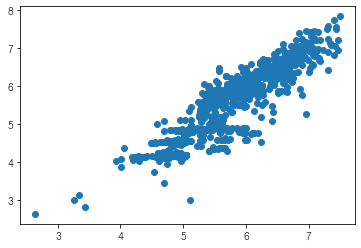

In [43]:
plt.scatter(X.단지내주차면수, y)